<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/convnet_best_practices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Deep Learning for Computer Vision - ConvNet Architecture Best Practices
In this notebook we present three architectural changes for convolutional layers that can improve the efficiency and the results of standard convolutional networks. The main changes are

1. Residual blocks
2. Batch normalization
3. Separable convolution

Finally we will implement all thse changes in a small version of the Xception architecture and will use the model on the cat and dogs dataset to compare its performance with the standard convolutional network model used in the notebook [*Deep Learning for Computer Vision*](computer_vision.ipynb)

## Residual connections
Deep neural networks are affected by the *vanishing gradients* problem for which the parameters become increasingly smaller. One solution to avoid such problem is to use a shortcut, that is to add the input to the output of a block of one or more layers. Residual connections have been introduced in the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)" by He et al.
![residual connection](https://github.com/luigiselmi/dl_tensorflow/blob/main/images/residual_connection.jpg?raw=1)

In [33]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

The shape of the output of a block of convolutional layers can change. For instance, more filters can be added while the height and width of the filters can shrink if a MaxPooling layer is added to a convolutional layer. In order to add the input tensor to the output they have to have the same shape.

In [4]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
residual = x
residual.shape

TensorShape([None, 30, 30, 32])

Let's say we add a block to the model that doubles the number of filters

In [5]:
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x.shape

TensorShape([None, 30, 30, 64])

In this case we can use a 1x1 convolutional layer without activation function that will simply project the input to the same number of 2D arrays

In [6]:
residual = layers.Conv2D(64, 1)(residual)
residual.shape

TensorShape([None, 30, 30, 64])

Now the input can be added to each filter

In [7]:
x = layers.add([x, residual])
x.shape

TensorShape([None, 30, 30, 64])

Now we see the case for which also the height and width of the filters changes

In [8]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
residual = x
residual.shape

TensorShape([None, 30, 30, 32])

For instance we double the number of filters like before and we also reduce the size of each filter

In [9]:
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x.shape

TensorShape([None, 15, 15, 64])

In this case we use again a 1x1 convolutional layer without activation function and with stride = 2 to match the size of the filters.

In [10]:
residual = layers.Conv2D(64, 1, strides=2)(residual)
residual.shape

TensorShape([None, 15, 15, 64])

Now we can add the input tensor to the output.

In [11]:
x = layers.add([x, residual])
x.shape

TensorShape([None, 15, 15, 64])

### An example of ConvNet with residual blocks
We build a simple convolutional network using three residual blocks, each containing two convolutional layers.   

In [12]:
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

We double the number of filters of each block, that is of each convolutional layer inside the block, and change their size in two blocks.

In [13]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 32)           896       ['rescaling[0][0]']           
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 32)           9248      ['conv2d_6[0][0]']            
                                                                                              

## Batch normalization
Data normalization is usually applied in machine learning algorithms where the input feautures have values of different order of magnitude, generally speaking, when their distribution is very different. Usually we subtract the mean to the input data and divide the result by the standard deviation. In classic machine learning algorithms is assumed that such transformation is enough to avoid problems. In deep neural networks where the data may pass through several layers with nonlinear activation functions we cannot assume that the output values, or distribution, of a layer or block of layers will stay within a certain range. A batch normalization layer, e.g. *BatchNormalization* in Keras, is a layer that can be added after a layer or block to normalize the data during training and inference time. The type of normalization is the same as discussed above. During the training phase the normalization is based on the current batch of data. At inference time the input data is normalized according to the exponential moving average and to the standard deviation of the batches seen during training. Batch normalization improves the gradient propagation and therefore deeper networks as the residual connections. A BatchNormalization layer can be added before the activation function as shown in the following code snippet. Another improvement is to remove the bias since the batch normalization will move the values around a zero mean distribution.    

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)

x = layers.Conv2D(32, 3, use_bias=False)(x) # the bias can be removed since the normalization will remove it anyway
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x) # apply the activation function after the nbatch normalization

Batch normalization is used in many deep learning architectures such as ResNet, EfficientNet, Xception.

## Separable convolutions
In a standard convolutional layer the filters are applied to each input feature map. The number of learnable parameters, without the bias, is given by

$$p_l = f_{l-1} \times k_l \times k_l \times f_l $$

so e.g. for a $3 \times 3$ kernel size, 64 input feature maps and 64 filters the number of parameters is 36864. if we assume that the feature maps are independent, that is there is no correlation between them, we might apply each filter to only one feature map and add them together. In this case the number of learnable parameters is

$$p_{l} = f_{l-1} \times k_l \times k_l + f_{l-1} \times f_l$$

So for the exampe above the number of paameters would be 4672, a reduction of almost a factor 8 in the number of parameters.

## The Xception architecture
We implement a small version of the Xception architecture that uses the improvement discussed so far: residual blocks, batch normalization, and separable convolutions. We use the model with the cats and dogs dataset. Since these are RGB images where each channel is higly correlated with the others, the architecture start with a standard depth-wise convolutional layer followed by blocks containning separable convolutional layers (*SeparableConv2D* layer in Keras).  

We download the dataset from Kaggle as in the [*Deep Learning for Computer Vision*](computer_vision.ipynb) notebook. We need to upload our token in order to access the dataset.

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lselmi","key":"c8a6ca5d3e0efc3c981490a3cbb4bb98"}'}

In [15]:
mkdir /root/.kaggle

In [16]:
mv kaggle.json /root/.kaggle/

In [17]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:03<00:00, 246MB/s]
100% 812M/812M [00:03<00:00, 221MB/s]


In [18]:
!unzip -qq /content/dogs-vs-cats.zip

In [19]:
!unzip -qq /content/train.zip

In [20]:
!find /content/train/ -type f | grep cat |wc -l

12500


In [21]:
!find /content/train/ -type f | grep dog |wc -l

12500


In [22]:
import os, shutil, pathlib
original_dir = pathlib.Path("/content/train/")
new_base_dir = pathlib.Path("/content/cats_vs_dogs_small")

In [23]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg"
            for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [24]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Finally we create three datasets for training, validation, and test

In [25]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [26]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_4[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d_15 (Conv2D)          (None, 176, 176, 32)         2400      ['rescaling_1[0][0]']         
                                                                                            

In [36]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="xception_like_convnet.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [41]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 10s 144ms/step - loss: 0.0445 - accuracy: 0.9825 - val_loss: 0.6721 - val_accuracy: 0.8720
Epoch 2/100
63/63 [==============================] - 10s 155ms/step - loss: 0.0547 - accuracy: 0.9795 - val_loss: 0.5363 - val_accuracy: 0.8890
Epoch 3/100
63/63 [==============================] - 9s 140ms/step - loss: 0.0531 - accuracy: 0.9825 - val_loss: 0.2977 - val_accuracy: 0.9230
Epoch 4/100
63/63 [==============================] - 10s 155ms/step - loss: 0.0509 - accuracy: 0.9825 - val_loss: 1.8429 - val_accuracy: 0.7120
Epoch 5/100
63/63 [==============================] - 9s 134ms/step - loss: 0.0460 - accuracy: 0.9800 - val_loss: 0.3758 - val_accuracy: 0.9090
Epoch 6/100
63/63 [==============================] - 10s 150ms/step - loss: 0.0396 - accuracy: 0.9860 - val_loss: 0.3223 - val_accuracy: 0.9200
Epoch 7/100
63/63 [==============================] - 9s 136ms/step - loss: 0.0480 - accuracy: 0.9835 - val_loss: 0.6514 - val_accuracy: 0.

In [42]:
def plot_results(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

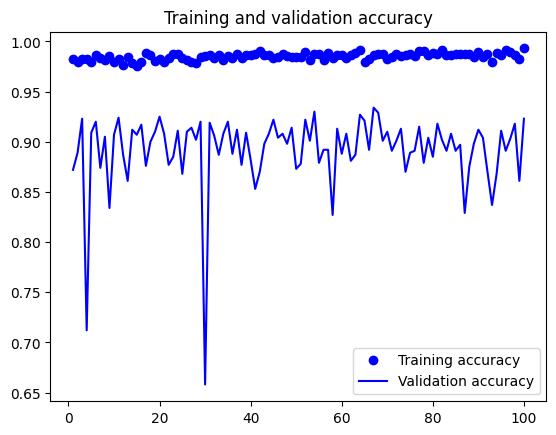

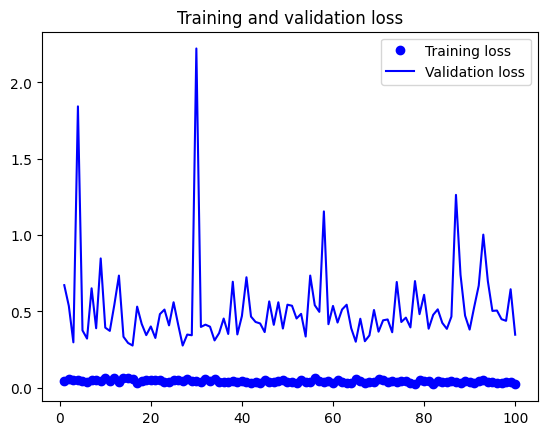

In [43]:
plot_results(history)

We can compare the accuracy on the test set with the model in the notebook [*Deep Learning for Computer Vision*](computer_vision.ipynb) with data augmentation that has 991041 parameters and had an accuracy of 84.5%

In [44]:
test_model = keras.models.load_model("xception_like_convnet.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 36ms/step - loss: 0.4026 - accuracy: 0.9020
Test accuracy: 0.902
